In [22]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import sys

from IPython import display

import matplotlib.pyplot as plt

In [2]:
sys.path.append("../../gated-graph-neural-network-samples/")
from utils import *

In [3]:
class GNN():
    def __init__(self, h_dim = 5, edge_types = 1):
        self.params = {}
        self.placeholders = {}
        self.weights = {}
        
        self.params["hidden_size"] = h_dim
        self.params["edge_types"] = edge_types
        self.params["use_edge_bias"] = True
        self.params['num_timesteps'] = 10
    
    
    def prepare_specific_graph_model(self) -> None:
        h_dim = self.params['hidden_size']
        # inputs
        self.placeholders['graph_state_keep_prob'] = tf.placeholder(tf.float32, None, name='graph_state_keep_prob')
        self.placeholders['edge_weight_dropout_keep_prob'] = tf.placeholder(tf.float32, None, name='edge_weight_dropout_keep_prob')
        self.placeholders['initial_node_representation'] = tf.placeholder(tf.float32,
                                                                          [None, None, self.params['hidden_size']],
                                                                          name='node_features')
        #self.placeholders['node_mask'] = tf.placeholder(tf.float32, [None, None], name='node_mask')
        self.placeholders['num_vertices'] = tf.placeholder(tf.int32, ())
        self.placeholders['adjacency_matrix'] = tf.placeholder(tf.float32,
                                                               [None, self.params["edge_types"], None, None])     # [b, e, v, v]
        self.__adjacency_matrix = tf.transpose(self.placeholders['adjacency_matrix'], [1, 0, 2, 3])         # [e, b, v, v]


        # weights
        self.weights['edge_weights'] = tf.Variable(glorot_init([self.params["edge_types"], h_dim, h_dim]))
        if self.params['use_edge_bias']:
            self.weights['edge_biases'] = tf.Variable(np.zeros([self.params["edge_types"], 1, h_dim]).astype(np.float32))
        with tf.variable_scope("gru_scope"):
            cell = tf.contrib.rnn.GRUCell(h_dim)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell,
                                                 state_keep_prob=self.placeholders['graph_state_keep_prob'])
            self.weights['node_gru'] = cell
        self.weights['last_dense'] = tf.Variable(glorot_init([h_dim, 2]))
        self.weights['last_bias'] = tf.get_variable('bias', shape = [2], dtype = tf.float32)
        
    
    def compute_final_node_representations(self) -> tf.Tensor:
        v = self.placeholders['num_vertices']
        h_dim = self.params['hidden_size']
        h = self.placeholders['initial_node_representation']                                                # [b, v, h]
        h = tf.reshape(h, [-1, h_dim])

        with tf.variable_scope("gru_scope") as scope:
            for i in range(self.params['num_timesteps']):
                if i > 0:
                    tf.get_variable_scope().reuse_variables()
                for edge_type in range(self.params["edge_types"]):
                    m = tf.matmul(h, tf.nn.dropout(self.weights['edge_weights'][edge_type],
                                                   keep_prob=self.placeholders['edge_weight_dropout_keep_prob'])) # [b*v, h]
                    m = tf.reshape(m, [-1, v, h_dim])                                                       # [b, v, h]
                    if self.params['use_edge_bias']:
                        m += self.weights['edge_biases'][edge_type]                                         # [b, v, h]
                    if edge_type == 0:
                        acts = tf.matmul(self.__adjacency_matrix[edge_type], m)
                    else:
                        acts += tf.matmul(self.__adjacency_matrix[edge_type], m)
                acts = tf.reshape(acts, [-1, h_dim])                                                        # [b*v, h]

                h = self.weights['node_gru'](acts, h)[1]                                                    # [b*v, h]
            last_h = tf.reshape(h, [-1, v, h_dim])
        return last_h
            
    def predict(self, last_h):
        last_h = tf.reshape(last_h, [-1, self.params["hidden_size"]])                                       # [b*v, h]
        
        logits = tf.matmul(last_h, self.weights['last_dense']) + self.weights['last_bias']
        
        output = tf.nn.softmax(logits)
        return output, logits
    
    def loss(self, logits, target):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = target, logits=logits))
        return loss
    

In [44]:
tf.reset_default_graph()
sess = tf.Session()


gnn = GNN(4)
gnn.prepare_specific_graph_model()
last_h = gnn.compute_final_node_representations()
out, logits = gnn.predict(last_h = last_h)

target = tf.placeholder(tf.float32, [None, 2])


loss = gnn.loss(logits, target)

In [45]:
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [46]:
sess.run(tf.global_variables_initializer())

In [159]:
#sess.run([last_h, out, logits, loss], feed_dict=feed_dict)

In [106]:
for i in range(100):
    l = sess.run([loss, train_step], feed_dict=feed_dict)

In [8]:
embs = np.load("../../data/gnn_prepared/embs.npy")
adjs = np.load("../../data/gnn_prepared/adjs.npy")
targets = np.load("../../data/gnn_prepared/target.npy")

In [9]:
train_embs, test_embs = embs[:800], embs[800:]
train_adjs, test_adjs = adjs[:800], adjs[800:]
train_targets, test_targets = targets[:800], targets[800:]

In [47]:
keep_p = 1

In [48]:
def iterate_minibatches(e,a,t, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(e.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, e.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield e[excerpt], a[excerpt], t[excerpt]

In [49]:
train_losses = []
test_losses = []

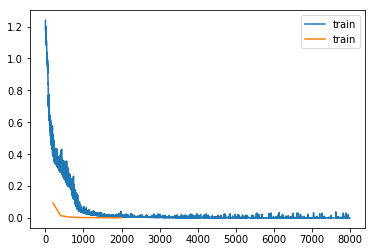

In [50]:
epochs = 10
for epoch in range(epochs):
    for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                train_embs, train_adjs, train_targets, 1)):

        batch_embs = batch_e[0][:,1:]
        batch_adj = batch_a[0][0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1
        
        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        batch_loss = sess.run([train_step,loss], feed_dict=feed_dict)
        
        train_losses.append(batch_loss[1])
    
    batch_loss = 0
    for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                test_embs, test_adjs, test_targets, 1)):

        batch_embs = batch_e[0][:,1:]
        batch_adj = batch_a[0][0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1
        
        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        curr_loss = sess.run(loss, feed_dict=feed_dict) / test_adjs.shape[0]
        batch_loss += curr_loss
        
    test_losses.append(batch_loss)
        
        
    if epoch%1==0:
        display.clear_output(wait=True)
        plt.plot(train_losses, label='train')
        plt.plot([i * test_adjs.shape[0] for i in range(1, epoch + 2)], test_losses, label='train')
        plt.legend()
        plt.show()
#         curr_loss += batch_loss[1]

#         if i % n == 0:
#             if i != 0:
#                 losses_each_n.append( curr_loss / n)
            
#             curr_loss = 0


#             display.clear_output(wait=True)
#             plt.plot(losses_each_n[1:], label='train')
#             plt.plot(val_x, val_losses, label='test')
#             plt.legend()
#             plt.show()
            
#     val_loss = sess.run(loss,  feed_dict={inp : np.hstack((X, X_emb[:,:5]))[800:].reshape(-1, 150), target: y[800:].reshape(-1, 100)})
#     val_losses.append(val_loss)
#     val_x.append(len(losses_each_n))
    
#     curr_loss == 0

        #print(batch_loss[1])

In [51]:
test_losses


[0.09385188516229397,
 0.01429815154522657,
 0.00623555688653141,
 0.003659928056877107,
 0.002481269122217782,
 0.001974190867040306,
 0.0015737661081948319,
 0.0013093689980451018,
 0.0010071926517412069,
 0.0011225687996920895]

In [52]:
emb_ES3 = np.load("../../data/gnn_prepared/ES3_22_embs.npy")
adj_ES3 = np.load("../../data/gnn_prepared/ES3_22_adj.npy")
#targets = np.load("../../data/gnn_prepared/target.npy"

In [54]:
feed_dict = {
    gnn.placeholders['graph_state_keep_prob'] : keep_p,
    gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
    gnn.placeholders['initial_node_representation'] : np.expand_dims(emb_ES3[:, 1:], 0) ,
    #gnn.placeholders['node_mask'] : adj,
    gnn.placeholders['num_vertices'] : adj_ES3.shape[0],
    gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(adj_ES3, 0), 0),
    target : batch_target
}

In [57]:
answ_ES3 = sess.run(out, feed_dict)[:,1]

In [58]:
import pickle

In [60]:
np.save("../../data/gnn_prepared/answ_ES3", answ_ES3)

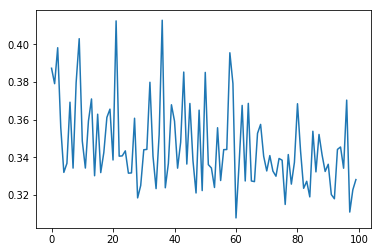

In [34]:
plt.plot(np.array(train_losses[:1000]).reshape((100, 10)).mean(1))

In [36]:
np.array(train_losses[:8]).reshape((4, 2))

array([[0.45203796, 0.44378713],
       [0.3275843 , 0.36068445],
       [0.41205674, 0.36924112],
       [0.29712653, 0.38831797]], dtype=float32)

In [37]:
train_losses

[0.45203796,
 0.44378713,
 0.3275843,
 0.36068445,
 0.41205674,
 0.36924112,
 0.29712653,
 0.38831797,
 0.36775297,
 0.45445147,
 0.2928272,
 0.3473108,
 0.3288225,
 0.33794945,
 0.5489891,
 0.43422952,
 0.31231597,
 0.39028674,
 0.49403295,
 0.30431944,
 0.28838766,
 0.32708678,
 0.29321948,
 0.352219,
 0.47319245,
 0.31894565,
 0.87456423,
 0.35313332,
 0.3370151,
 0.36430487,
 0.3360098,
 0.33649266,
 0.39186978,
 0.33396617,
 0.2943497,
 0.347366,
 0.30049285,
 0.27278447,
 0.60881895,
 0.3362414,
 0.33381307,
 0.35055637,
 0.3049141,
 0.37563193,
 0.33320603,
 0.2965061,
 0.32450998,
 0.29923183,
 0.3666961,
 0.33481157,
 0.39787325,
 0.38857955,
 0.3127735,
 0.31740192,
 0.33591637,
 0.38111082,
 0.2962702,
 0.31868818,
 0.29665905,
 0.3225621,
 0.3708034,
 0.35995975,
 0.3093045,
 0.3056755,
 0.32291114,
 0.35758784,
 0.3245985,
 0.3282951,
 0.7185185,
 0.29502362,
 0.29776636,
 0.35386366,
 0.28098166,
 0.33919075,
 0.35501,
 0.32119855,
 0.3094271,
 0.39682552,
 0.36570862,
 0

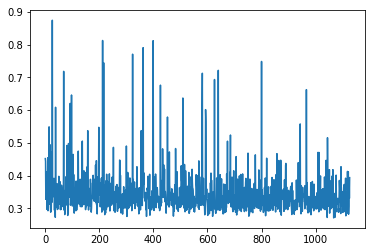

In [33]:
plt.plot(train_losses)

In [92]:
adj = np.array([[0,1],[0,0]]).reshape((1,1,2,2))
initial_nodes_representations = np.random.random((1, 2,2))
n_v = 2


In [102]:
feed_dict = {
    gnn.placeholders['graph_state_keep_prob'] : keep_p,
    gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
    gnn.placeholders['initial_node_representation'] : initial_nodes_representations,
    #gnn.placeholders['node_mask'] : adj,
    gnn.placeholders['num_vertices'] : n_v,
    gnn.placeholders['adjacency_matrix'] : adj,
    
    target : np.array([[0, 1], [0, 1]])
}